# Deep learning A-Z : Building an ANN

This notebook is my response to the first homework of the course called *Deep Learning A-Z™: Hands-On Artificial Neural Networks* accessible here : https://www.udemy.com/deeplearning/

In this notebook, we are going to build an ANN using keras and by following instructions given on the course. This neurals network will predict, for a customer of a bank, if this customer is going to leave the bank or not. We are going to train our ann with a dataset containing data about approximately 10000 clients, which also includes a response column in which we can see whether the client stayed or not in the bank.

### Imports

In [220]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Data preprocessing

In [161]:
path_train = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'ressources/Artificial_Neural_Networks/Churn_Modelling.csv')
dataset = pd.read_csv(path_train)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


"Exited" is our response column, its the 14th column, we are going to need this information to modify the template given by the course to make it works for this case. The three first columns have no impact on the response so we will not include it in out training table.

As shown in the course, we are going to preprocess our data using the template given in the course:

In [4]:
X = dataset.iloc[:, 3:13].values # we modify indexes according to what we saw with the info() method of the dataset
y = dataset.iloc[:, 13].values # idem
X[1]

array([608, 'Spain', 'Female', 41, 1, 83807.86, 1, 0, 1, 112542.58],
      dtype=object)

Now we have to encode our categorical variables. We are going to do it using the template of the course. Here we have two categorical columns (Geography and Gender) so we have to create to encoders:

In [5]:
# Encoding categorical data
labelencoder_X_geo = LabelEncoder()
X[:, 1] = labelencoder_X_geo.fit_transform(X[:, 1])
labelencoder_X_gender = LabelEncoder()
X[:, 2] = labelencoder_X_gender.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

In [171]:
X[0]

array([0.0000000e+00, 0.0000000e+00, 6.1900000e+02, 0.0000000e+00,
       4.2000000e+01, 2.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 1.0000000e+00, 1.0134888e+05])

In [6]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
X_train.shape

(8000, 11)

Our data are now preprocessed ! We can start building our model:

### 2. Let's build our ANN

In [8]:
# Initializing our ANN
classifier = Sequential()

As a reminder, here are all the steps we must follow for training an ANN with stochastic gradient descent method. Dense function will be used for step 1. From step 2, we know that each features is attributed to one node, so we have to create 11 input nodes in our input layer. 
We also have to choose an activation function (step 3) as we saw in the course, we will use the best one for our hidden layers (based on experiment) : the rectifier function. The sigmoid function is a very good option for our output layer because it will gives us probabilities for each classes.
After that, we will use learning rate to choose how weights are updated and we will also think about how many epochs we are going to do. Let's go !

![title](images/steps.png)

In [9]:
# Adding the input layer and the first hidden layer of our ANN
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape = (11,)))

- *units* param corresponds to the number of node of the layer:

**tip :** choose the number of nodes in the hidden layers as the average of the number of nodes in the input layer and the number of nodes in the output layer
Here we have 11 nodes in input layer and 1 node in output layer (because binary output) so we choose 6 nodes in hidden layers

- *kernel_initializer* param corresponds to the way we are initializing our weights:

As we saw during the course, weights must be initialized as small numbers close to zero. The random uniform function allows us to initialize our weights in this way.

- *activation* param corresponds to the activation function for hidden layers:

We choose 'relu' for rectifier function.

- *input_shape* is the number of nodes in the input layer

Now, let’s create our second hidden layer, which will be the same as the first one. Here, we don’t have to specify the input shape because it can deduce this with the previous hidden layer. For the first one, there was no hidden layer yet created so we had to specify it. 

In [10]:
# Adding the second hidden layer
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))

Finally, we have to add our output layer. We have to change the activation function because we said that the activation function of our output layer will be the sigmoid function. We also want a single binary output so the units (output dimension) will be set to 1.

In [11]:
# Adding the output layer
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

Now, we are going to apply stochastic gradient method on the whole neural network by compiling our model. Indeed, we have built our ANN but the weigths are still initialized, so now we need to find the best weights that will make our NN the most powerful.

In [12]:
# Compilling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

- *optimizer* is the algorithm which will be used to find the optimal set of weights in the ANN, here we will use (as we seen in the course) the stochastic gradient descent method. There are several types of this method, a very efficient one is called 'adam', we will use this one.

- *loss* is the loss function to be optimized within the SGD method. We will use here a log loss because the activation function of our output layer is the sigmoid function (this is the same as for logistic regression model).
**tip**: for more than two categories, the log loss function is called "categorical_crossentropy"

- *metrics* is the criterion that we use to evaluate our model. Here we are going to choose 'accuracy'.

Now we are going to train our NN with the fit method

In [13]:
# Training the ANN
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
8000/8000 [==============================] - 2s 227us/step - loss: 0.4929 - acc: 0.7952
Epoch 2/100
8000/8000 [==============================] - 1s 178us/step - loss: 0.4190 - acc: 0.7960
Epoch 3/100
8000/8000 [==============================] - 2s 192us/step - loss: 0.4102 - acc: 0.7960
Epoch 4/100
8000/8000 [==============================] - 2s 226us/step - loss: 0.4016 - acc: 0.8229
Epoch 5/100
8000/8000 [==============================] - 2s 198us/step - loss: 0.3941 - acc: 0.8295
Epoch 6/100
8000/8000 [==============================] - 2s 202us/step - loss: 0.3872 - acc: 0.8309
Epoch 7/100
8000/8000 [==============================] - 2s 209us/step - loss: 0.3816 - acc: 0.8365
Epoch 8/100
8000/8000 [==============================] - 2s 216us/step - loss: 0.3775 - acc: 0.8431
Epoch 9/100
8000/8000 [==============================] - 1s 182us/step - loss: 0.3734 - acc: 0.8447
Epoch 10/100
8000/8000 [==============================] - 1s 168us/step - loss: 0.3706 - acc: 0.8474

- *batch_size* is the number of observations after which you want to update the weights.

- *epochs*, an epoch is an iteration over the entire x and y data provided. We need to repeat step one to six several time (number of epoch) on our dataset to train the model.

For this two arguments, there is no rule and the experimentation is the best method to find out the best number to input.

After running this cell, we can see how stochastic gradient descent if performing on our dataset and how accuracy is improving as the number of epochs realised increases.

### 3. Making predictions and evaluating model

Finally, we can make our prediction:

In [14]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5) # convert probabilities to binary output

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1539,   56],
       [ 212,  193]])

We can do a better plot of the confusion matrix:

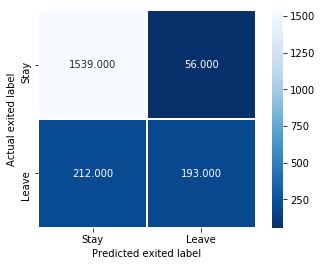

In [27]:
fig = plt.subplot()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual exited label')
plt.xlabel('Predicted exited label')
fig.xaxis.set_ticklabels(['Stay', 'Leave'])
fig.yaxis.set_ticklabels(['Stay', 'Leave']);
plt.show()

We have 1539 + 193 = 1732 correct predictions and 268 incorrect predictions. We can calculate the accuracy on test dataset (so this is the accuracy on new observations):

In [28]:
accuracy = 1732/2000
accuracy

0.866

### 4. Homework

Use our ANN model to predict if the customer with the following informations will leave the bank: 

- Geography: France
- Credit Score: 600
- Gender: Male
- Age: 40 years old
- Tenure: 3 years
- Balance: 60000 dollars
- Number of Products: 2
- Does this customer have a credit card ? Yes
- Is this customer an Active Member: Yes
- Estimated Salary: 50000 dollars

So should we say goodbye to that customer ?

Let's begin by creating a dataframe containing the observation:

In [154]:
columns = dataset.columns.tolist()
data = [0,0,0, 600, 'France', 'Male', 40, 3, 60000.00, 2, 1, 1, 50000.00, 0]
table = {columns[n]:[data[n]] for n in range(14)}
homework_customer = pd.DataFrame(table)
homework_customer.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,0,600,France,Male,40,3,60000.0,2,1,1,50000.0,0


We can now add our observation to our dataset:

In [192]:
dataset_homework = dataset.copy()
dataset_homework = dataset_homework.append(homework_customer)
X_homework = dataset_homework.iloc[:, 3:13].values
y_homework = dataset_homework.iloc[:, 13].values # idem
X_homework[10000] # here is our observation

array([600, 'France', 'Male', 40, 3, 60000.0, 2, 1, 1, 50000.0],
      dtype=object)

Now, we can standardize the data like above (encode cathegorical features and feature scaling) and make the prediction:

In [191]:
X_homework[:, 1] = labelencoder_X_geo.fit_transform(X_homework[:, 1])
X_homework[:, 2] = labelencoder_X_gender.fit_transform(X_homework[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X_homework = onehotencoder.fit_transform(X_homework).toarray()
X_homework = X_homework[:, 1:]
X_homework = sc.transform(X_homework)
homework_observation = X_homework[10000:]
homework_prediction = classifier.predict(homework_observation)
homework_prediction

array([[0.04758769]], dtype=float32)

The model predict a probability of 0.047 for this customer to leave the bank, so this customer is going to **stay** in the bank.

### 5. Solution

There was an easiest way to do it. The fact is that the StandarScaler object will apply the same scale than previously when it was fitted. Futhermore, We could just look at the dummies variables of a similar column (France and Male obs) to create an array, there was no need to reapply encoders:

In [189]:
new_prediction = classifier.predict(sc.transform(np.array([[0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])))
new_prediction

array([[0.04758769]], dtype=float32)

Same result than found above !

### 6. Evaluating the ANN

It’s important to evaluate the model to ensure that accuracy is not very different from one training to another, in other words we want to ensure that our model has a low variance. To evaluate our model, we will use the K-fold cross validation method.


In [201]:
def build_ann():
    classifier = Sequential()
    classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape = (11,)))
    classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_ann, batch_size=10, epochs=100, verbose=0)
accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=1)

In [202]:
accuracies

array([0.85999999, 0.8325    , 0.88124999, 0.84874999, 0.87124999,
       0.83375   , 0.8325    , 0.845     , 0.8175    , 0.86374999])

Now, let's calculate the true accuracy of our model and its variance:

In [215]:
mean = accuracies.mean()
variance = accuracies.std()
print('Mean accuracy:', mean, '\nVariance:', variance)

Mean accuracy: 0.8486249951273204 
Variance: 0.01912499840888716


The accuracy of 86% obtained in our first training of the model was not relevant ! But now, let's try to reach it by tuning our model !

### 7. Dropout regularization

Let's add some dropout regularization to our two hidden layers to reduce overfitting.
At each iteration of the training some neurons of your artificial neural network are randomly disabled to prevent them from being too dependent on each other when they learn the correlations and therefore, by overwriting these neurons the artificial neural network learns several independent correlations in the data because each time there is not the same configuration of the neurons. And the fact that we get these independent correlations of the data, thanks to the fact that the neurons work more independently, that prevents the neurons from learning too much and therefore that prevents overfitting.

- *p* is the fraction of the neurons we want to drop. In general, begin with 10% and increase this value (by 10% steps) if there is still overfitting. Don't try to go over 50% to avoid underfitting.

In [219]:
# Initializing our ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer of our ANN with dropout
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape = (11,)))
classifier.add(Dropout(p=0.1)) 
# Adding the second hidden layer with dropout
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
classifier.add(Dropout(p=0.1))
# Adding the output layer
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# Compilling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 8. Model tuning (homework : get over 86% accuracy)

In [ ]:
def build_ann(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu', input_shape = (11,)))
    classifier.add(Dropout(p=0.1)) 
    classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dropout(p=0.1)) 
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn=build_ann, verbose=1)
parameters = {
    'batch_size' : [25, 38],
    'epochs' : [100, 510],
    'optimizer' : ['adam', 'rmsprop']
}
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print('Best accuracy:', best_accuracy, '\nBest parameters:', best_params)

Epoch 1/10
6400/6400 [==============================] - 9s 1ms/step - loss: 0.5805 - acc: 0.7959
Epoch 2/10
6400/6400 [==============================] - 2s 342us/step - loss: 0.4458 - acc: 0.7980
Epoch 3/10
6400/6400 [==============================] - 2s 311us/step - loss: 0.4412 - acc: 0.7980
Epoch 4/10
6400/6400 [==============================] - 2s 299us/step - loss: 0.4347 - acc: 0.7980
Epoch 5/10
6400/6400 [==============================] - 2s 305us/step - loss: 0.4321 - acc: 0.7980
Epoch 6/10
6400/6400 [==============================] - 2s 301us/step - loss: 0.4314 - acc: 0.7980
Epoch 7/10
6400/6400 [==============================] - 2s 322us/step - loss: 0.4304 - acc: 0.7980
Epoch 8/10
6400/6400 [==============================] - 2s 308us/step - loss: 0.4315 - acc: 0.7980
Epoch 9/10
6400/6400 [==============================] - 2s 308us/step - loss: 0.4269 - acc: 0.7980
Epoch 10/10
6400/6400 [==============================] - 2s 243us/step
Epoch 1/10
6400/6400 [==================